<a href="https://colab.research.google.com/github/AkhilaSan/LFP_Analysis_With_Pynapple/blob/main/LFP_Analysis_With_Pynapple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook utalizes pynapple toolbox to filter theta frequencies from LFP recordings.

Experiment details: delivering optogenetic stimulation (different frequencies and type) to the brain and measuring arousal related behavior (pupil diameter, locomotion on treadmill, facial motion, and hippocampal local field potentials) in head fixed mice. (N=1)

In [1]:
#Install pynapple
pip install pynapple

In [2]:
#Importing necessary modules

import math
import os

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import pynapple as nap

import scipy.io as sio
from scipy import signal

In [3]:
#Downloading LFP Data
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/analysis M3_round2.mat')

/usr/local/lib/python3.12/dist-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
#Downloading the experiment trial types protocol
data2 = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/my_data2.mat')

In [5]:
#Extract the stimulation type for each trial information
extracted_strings = []

# data2['trialString2'] is likely a 2D array, e.g., (1, num_trials)
# Each element data2['trialString2'][0, i] is an array containing a single string
if 'trialString2' in data2 and isinstance(data2['trialString2'], np.ndarray):
    # Flatten the outer array if it has multiple dimensions that are 1
    flat_array = data2['trialString2'].flatten()

    for item in flat_array:
        # Each item is expected to be a NumPy array like array(['string_value'], dtype='<UXX')
        if isinstance(item, np.ndarray) and item.size == 1:
            extracted_strings.append(item.item()) # .item() extracts the scalar from a 0-D array
        else:
            # Handle cases where item might be a direct string or bytes, though less likely based on inspection
            if isinstance(item, str):
                extracted_strings.append(item)
            elif isinstance(item, bytes):
                extracted_strings.append(item.decode('utf-8', errors='ignore'))
            else:
                print(f"Warning: Encountered unexpected type for item: {type(item)}. Skipping or converting to string.")
                extracted_strings.append(str(item)) # Attempt to convert to string if type is unexpected

print(f"Successfully extracted {len(extracted_strings)} strings.")
print(f"First 10 extracted strings: {extracted_strings[:10]}")

# You can now use 'extracted_strings' as your single array (list) of strings


Successfully extracted 120 strings.
First 10 extracted strings: ['20Hz pulse', '50Hz sin', '50Hz sin', '10Hz sin', '10Hz pulse', '50Hz pulse', '20Hz pulse', '20Hz sin', '50Hz sin', '20Hz pulse']


In [6]:
#Define the LFP and Stimulation Data (LFP aquired at 5khz was preprocessed and downsampled to 1250hz)
lfp_data = data['lfp'];

In [7]:
#Identifying the opto stim onsets (2 sec jitter filter)
thresh_adc = 1500
thresh_t = 1250 * 2

abovethresh = np.where(lfp_data[0,0][3][:,14] > thresh_adc)[0]
diffs = np.diff(abovethresh, prepend=0)
onsetInds = np.where(diffs > thresh_t)[0]

onsets = abovethresh[onsetInds]

#Truncating the trails to the siz of the onsets (experiment was stopped early)
trialString = extracted_strings[0:onsets.size]

In [9]:
#Defining Intervals as 10 sec before onset to 25 sec after onset
time_array = lfp_data[0,0][4][:,0] # Corrected: Use the LFP time vector

# Convert onset indices to actual times
onset_times = time_array[onsets]

# Define start and end times for each interval
start_times = onset_times - 10  # 10 seconds before onset
end_times = onset_times + 25    # 25 seconds after onset

# Create the IntervalSet
interval_set = nap.IntervalSet(start_times, end_times)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


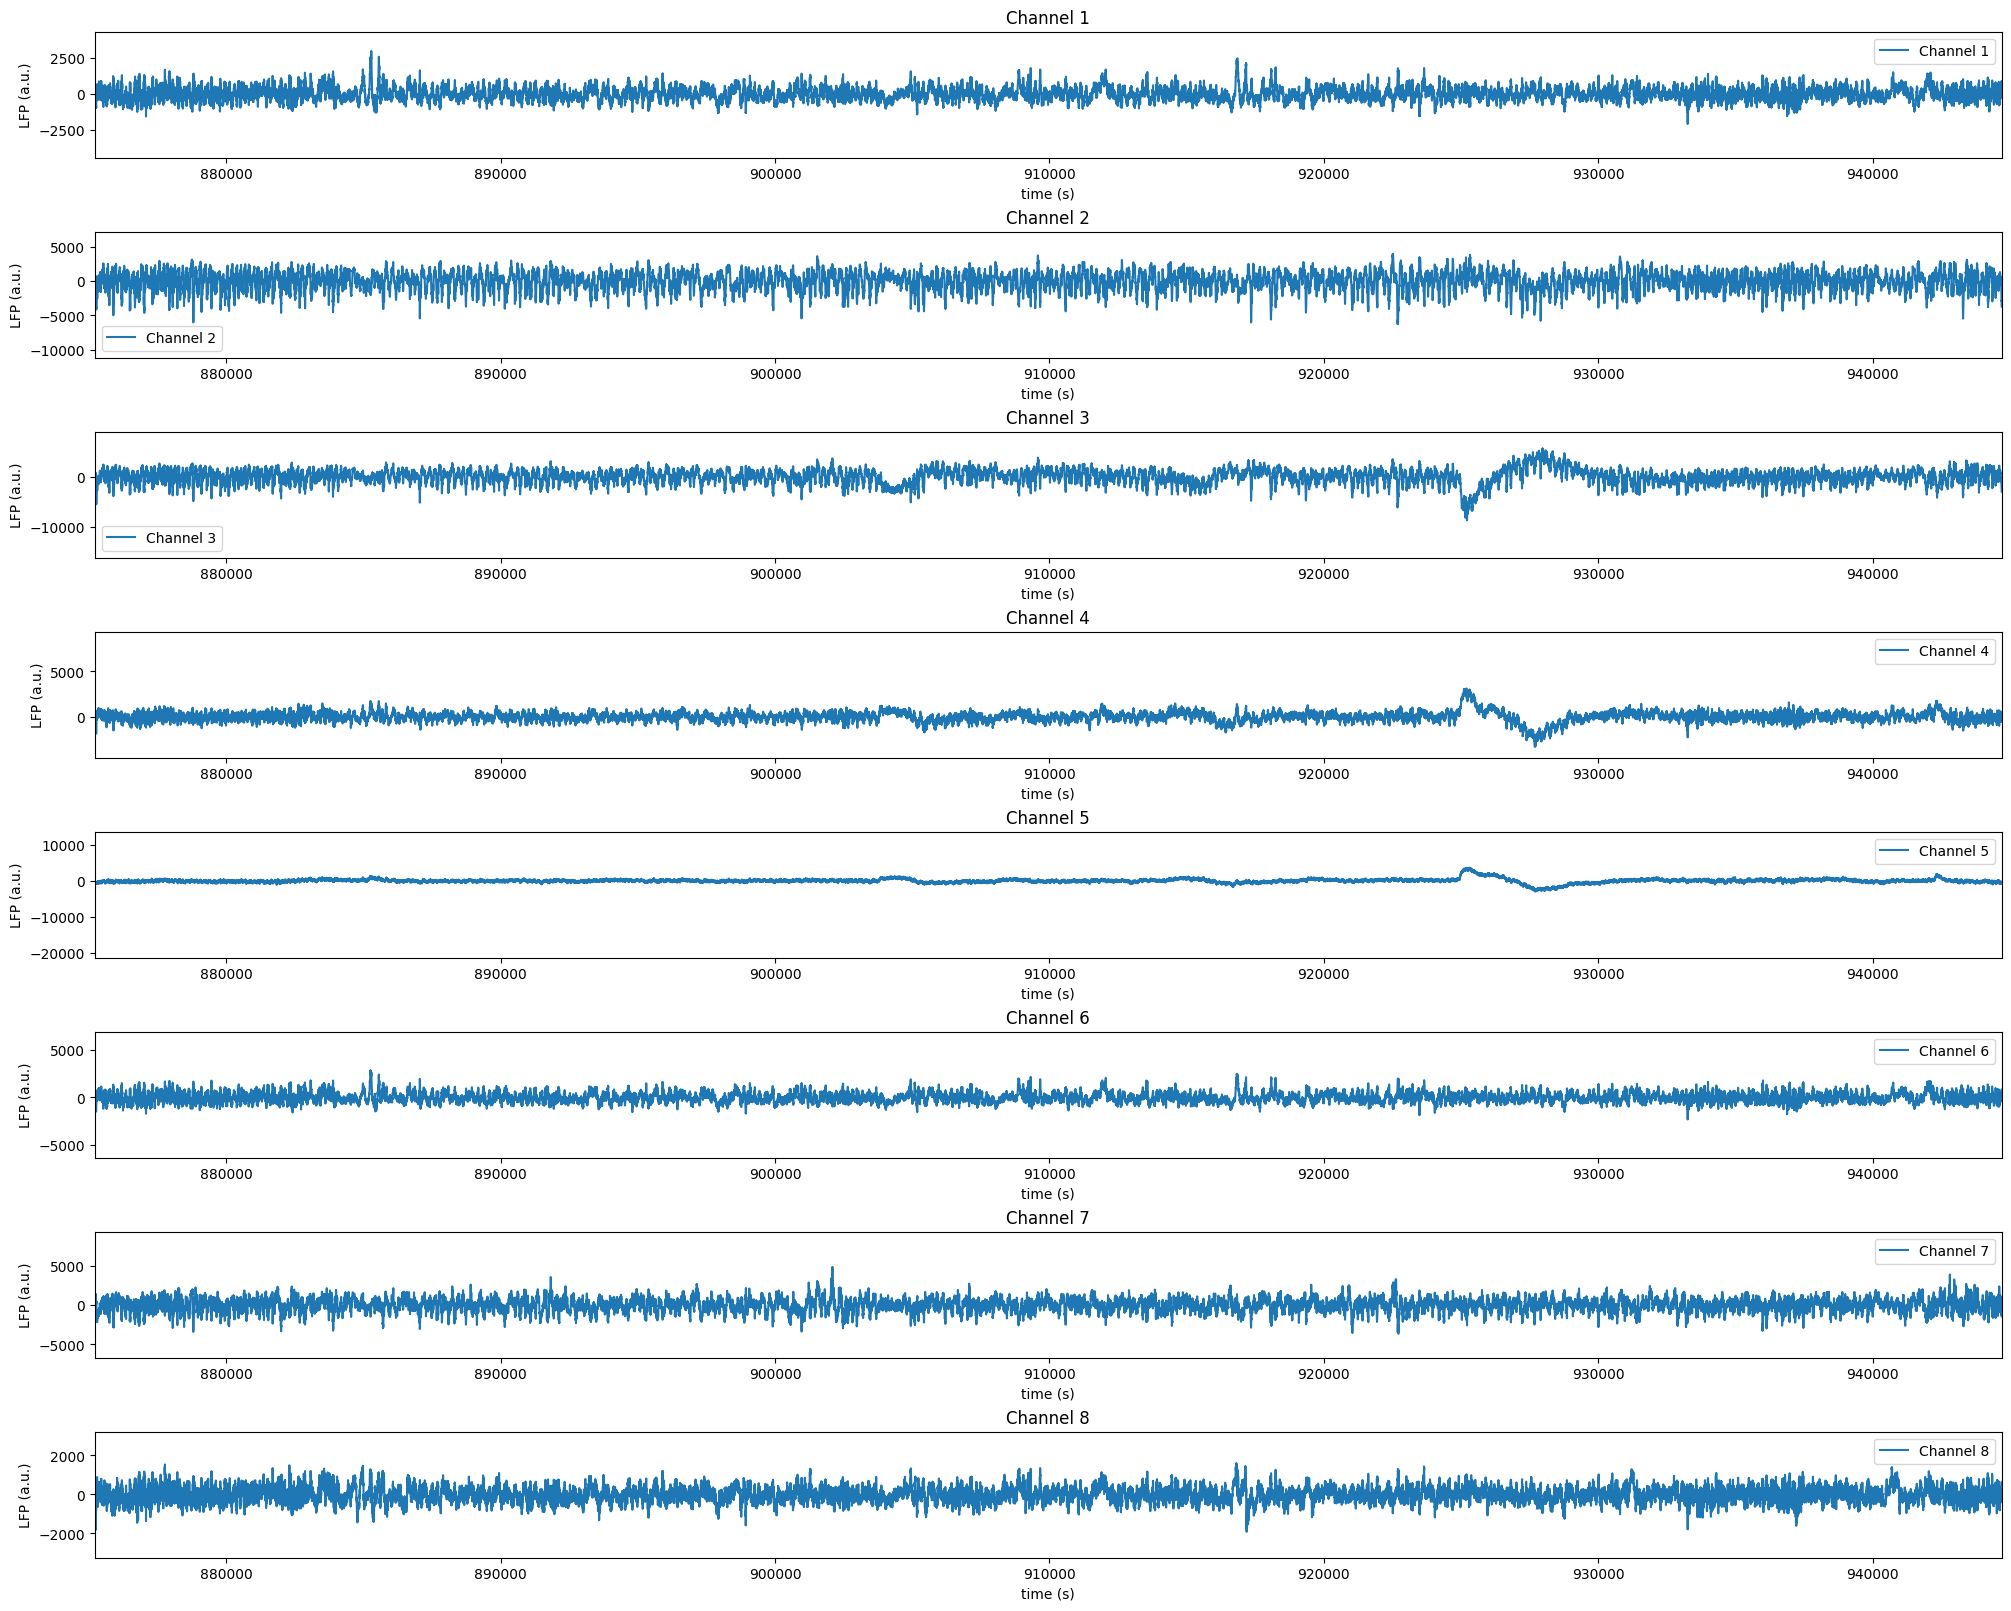

In [25]:
#Plotting the lfp data for the first interval

fig = plt.figure(constrained_layout=True, figsize=(20, 16))
# Create a dictionary to hold axes for each channel dynamically
axd = fig.subplot_mosaic([[f"ephys {i+1}"] for i in range(8)],
                         height_ratios=[1]*8)

for i in range(8):
    channel_key = f"ephys {i+1}"
    axd[channel_key].plot(lfp_data[0,0][3][:,i], label=f"Channel {i+1}")
    axd[channel_key].set_title(f"Channel {i+1}")
    axd[channel_key].set_ylabel("LFP (a.u.)")
    axd[channel_key].set_xlabel("time (s)")
    axd[channel_key].set_xlim(onsets[1], onsets[2])
    axd[channel_key].margins(0)
    axd[channel_key].legend()

plt.show()

In [26]:
#Computing the power spectral density for all 8 channels of lfp probe
FS = 1250;

lfp_tsd_channels = []
all_powers = []

for i in range(8):
  lfp_tsd = nap.Tsd(t=lfp_data[0,0][4][:,0], d=lfp_data[0,0][3][:,i])
  lfp_tsd_channels.append(lfp_tsd)
  power = nap.compute_power_spectral_density(lfp_tsd, fs=FS)
  all_powers.append(power)

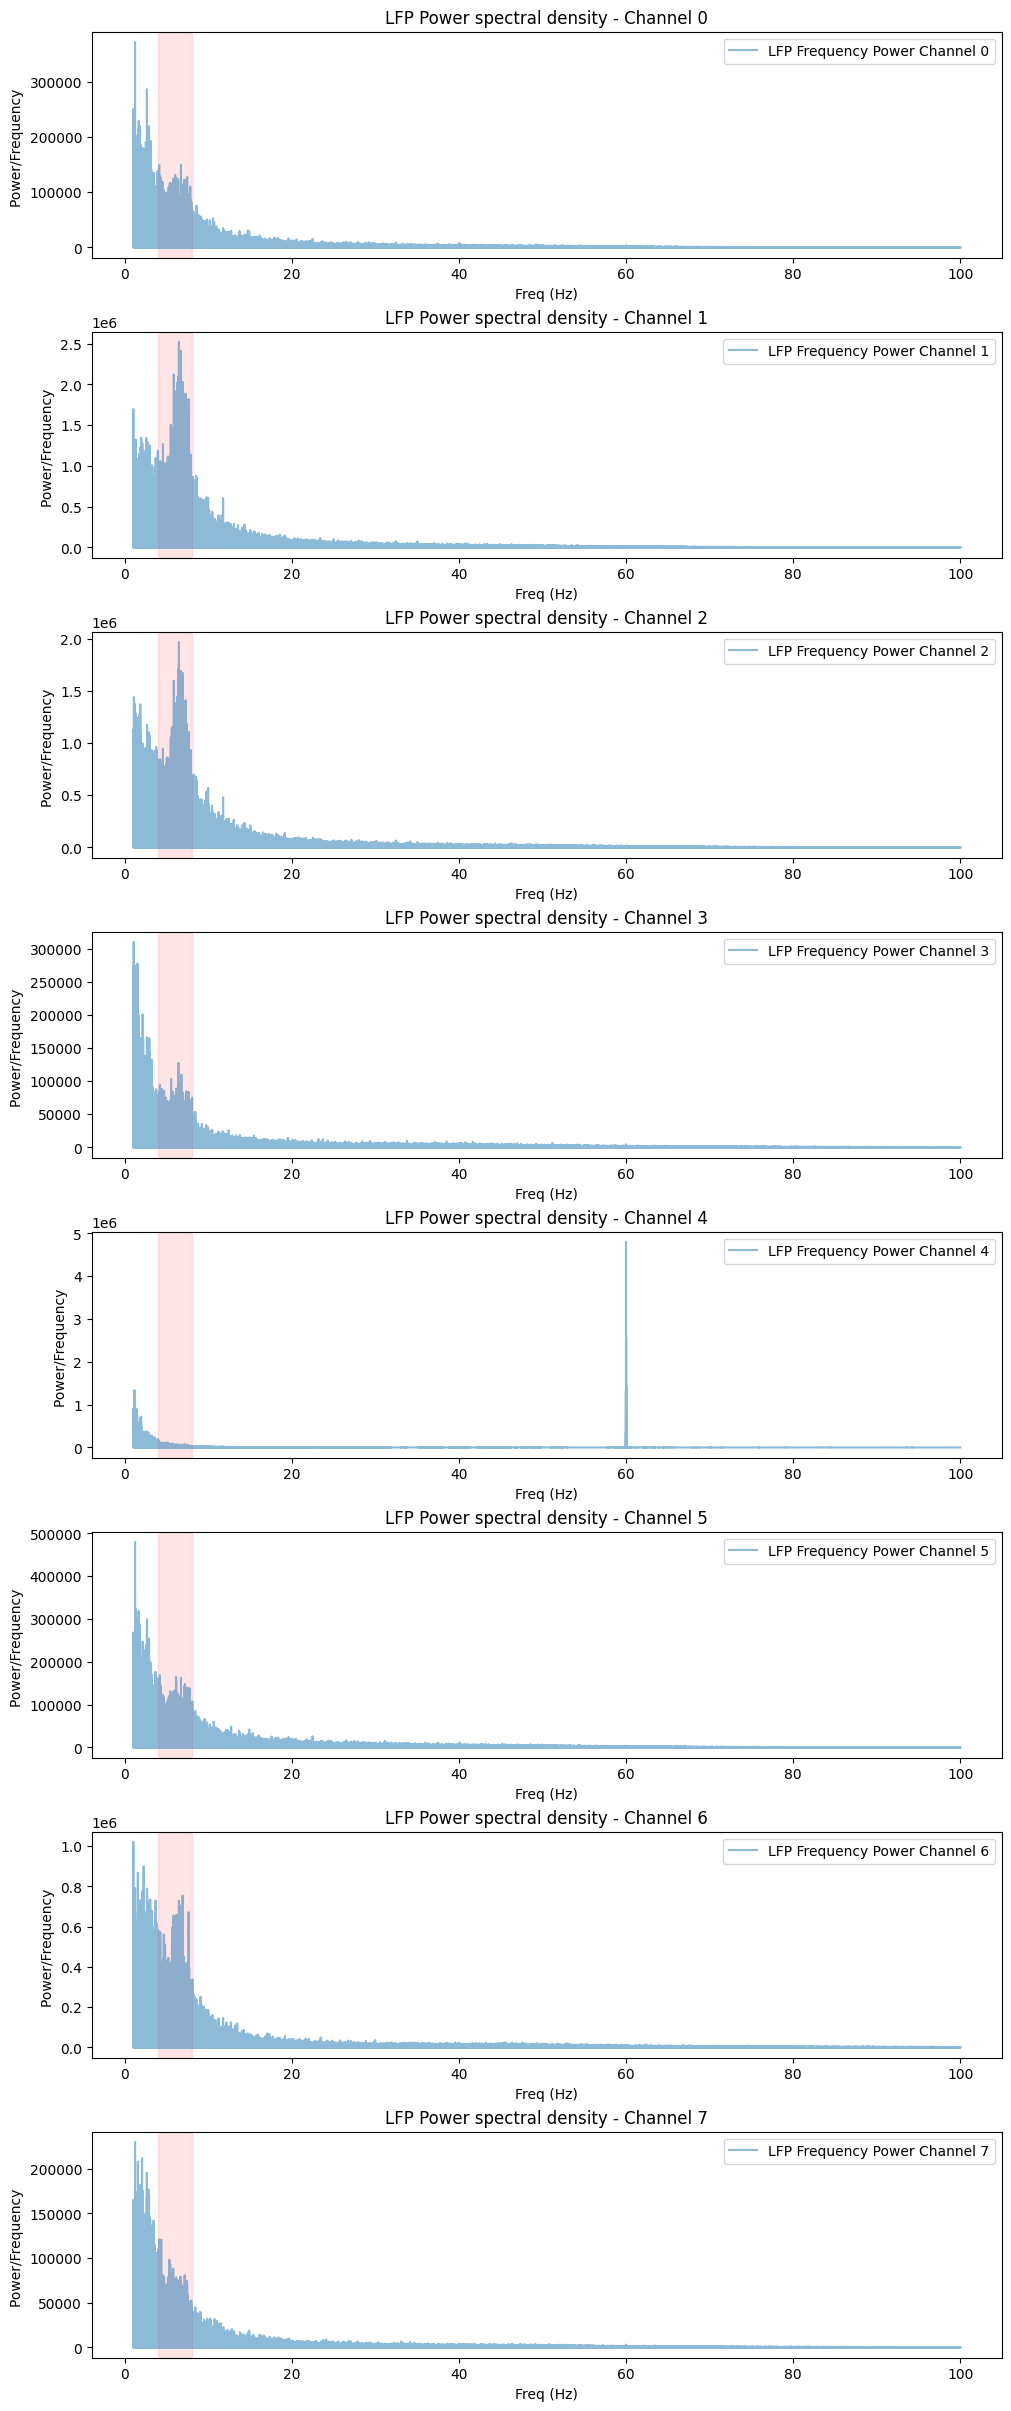

In [27]:
#Plotting power spectral density for ech channel
fig, axs = plt.subplots(8, 1, constrained_layout=True, figsize=(10, 24))

for i in range(8):
    current_power = all_powers[i]
    ax = axs[i]
    ax.plot(
        current_power[(current_power.index >= 1.0) & (current_power.index <= 100)],
        alpha=0.5,
        label=f"LFP Frequency Power Channel {i}",
    )
    ax.axvspan(4, 8, color="red", alpha=0.1)
    ax.set_xlabel("Freq (Hz)")
    ax.set_ylabel("Power/Frequency ")
    ax.set_title(f"LFP Power spectral density - Channel {i}")
    ax.legend()

plt.show()

In [29]:
#Identifying the channel with the best theta signal (biggest area under the curve from 4-10Hz)
theta_band_powers = []

for i, power_tsd in enumerate(all_powers):
    # Filter the PSD to the theta band (4-10 Hz)
    theta_power_spectrum = power_tsd[(power_tsd.index >= 4.0) & (power_tsd.index <= 10.0)]

    # Calculate the integrated power within the theta band
    # The 'd' attribute contains the data for Tsd objects
    integrated_theta_power = theta_power_spectrum.iloc[:, 0].sum()
    theta_band_powers.append(integrated_theta_power)

# Find the channel with the maximum integrated theta power
best_theta_channel_index = np.argmax(theta_band_powers)
best_theta_power_value = theta_band_powers[best_theta_channel_index]

print(f"Integrated Theta Power (4-10 Hz) for each channel:")
for i, power_val in enumerate(theta_band_powers):
    print(f"  Channel {i+1}: {power_val:.4f}")

print(f"\nThe channel with the best theta signal (highest integrated power in 4-10 Hz band) is Channel {best_theta_channel_index + 1} with an integrated power of {best_theta_power_value:.4f}.")

Integrated Theta Power (4-10 Hz) for each channel:
  Channel 1: 510285989.6474
  Channel 2: 6571377808.8348
  Channel 3: 5003195885.0042
  Channel 4: 353181772.2351
  Channel 5: 348351306.4987
  Channel 6: 575753024.6492
  Channel 7: 2191303978.0153
  Channel 8: 346193194.2968

The channel with the best theta signal (highest integrated power in 4-10 Hz band) is Channel 2 with an integrated power of 6571377808.8348.


In [30]:
#Filtering 4-10Hz freq for best channel
tsd_lfp_channel2 = lfp_tsd_channels[1].restrict(interval_set)
theta_band = nap.apply_bandpass_filter(tsd_lfp_channel2, cutoff=(4.0, 10.0), fs=FS)

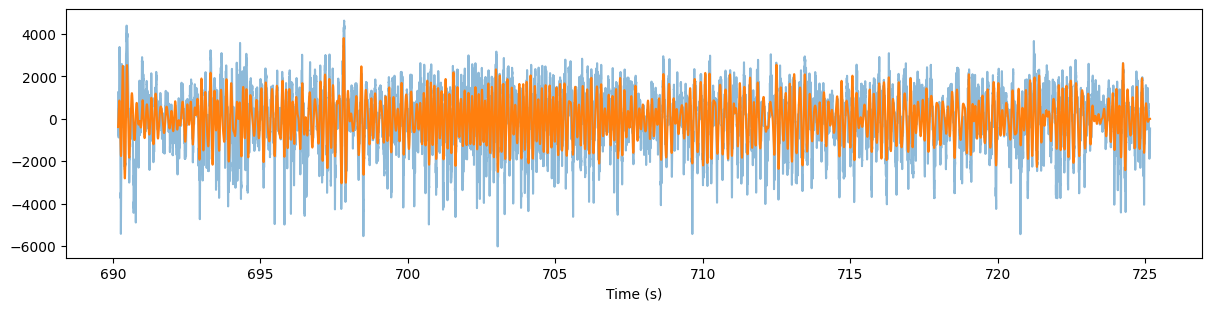

In [32]:
#Plotting the raw and filtered lfp signal for first interval
plt.figure(constrained_layout=True, figsize=(12, 3))
plt.plot(tsd_lfp_channel2.restrict(interval_set[1]), alpha=0.5)
plt.plot(theta_band.restrict(interval_set[1]))
plt.xlabel("Time (s)")
plt.show()

In [33]:
#calculating the phase
theta_phase = nap.Tsd(t=theta_band.t, d=np.angle(signal.hilbert(theta_band)))

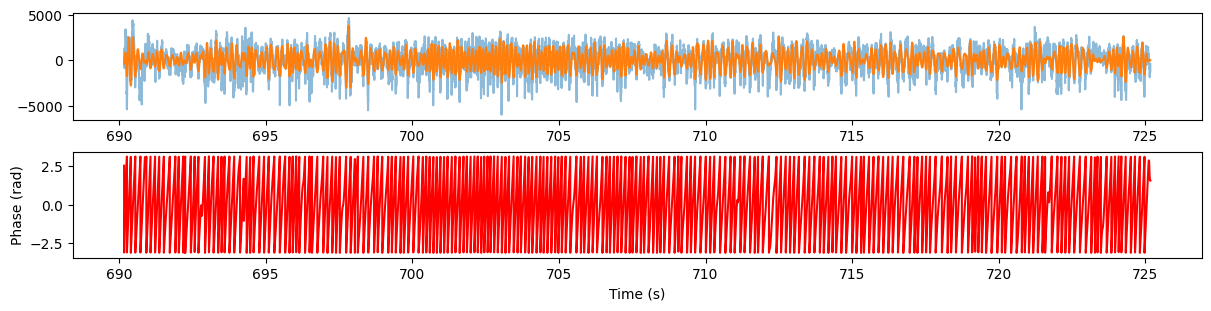

In [34]:
#plotting the phase for the first interval
plt.figure(constrained_layout=True, figsize=(12, 3))
plt.subplot(211)
plt.plot(tsd_lfp_channel2.restrict(interval_set[1]), alpha=0.5)
plt.plot(theta_band.restrict(interval_set[1]))
plt.subplot(212)
plt.plot(theta_phase.restrict(interval_set[1]), color='r')
plt.ylabel("Phase (rad)")
plt.xlabel("Time (s)")
plt.show()

In [35]:
#Calculating the power
analytic_signal = signal.hilbert(theta_band)
theta_power = abs(analytic_signal)**2

In [36]:
#Restucturing the theta power by trials tsd
theta_power_tsd = nap.Tsd(t=theta_band.t, d=theta_power)

theta_power_by_trial = []
for i, interval in enumerate(interval_set):
    # Restrict theta_power_tsd to the current interval
    restricted_power = theta_power_tsd.restrict(interval)
    theta_power_by_trial.append(restricted_power)

Successfully separated theta_power into 72 trials.
Example: The first trial has 43751 data points.


In [37]:
#Averaging the theta power for all trials
average_theta_power = np.mean(theta_power_by_trial,axis=0)

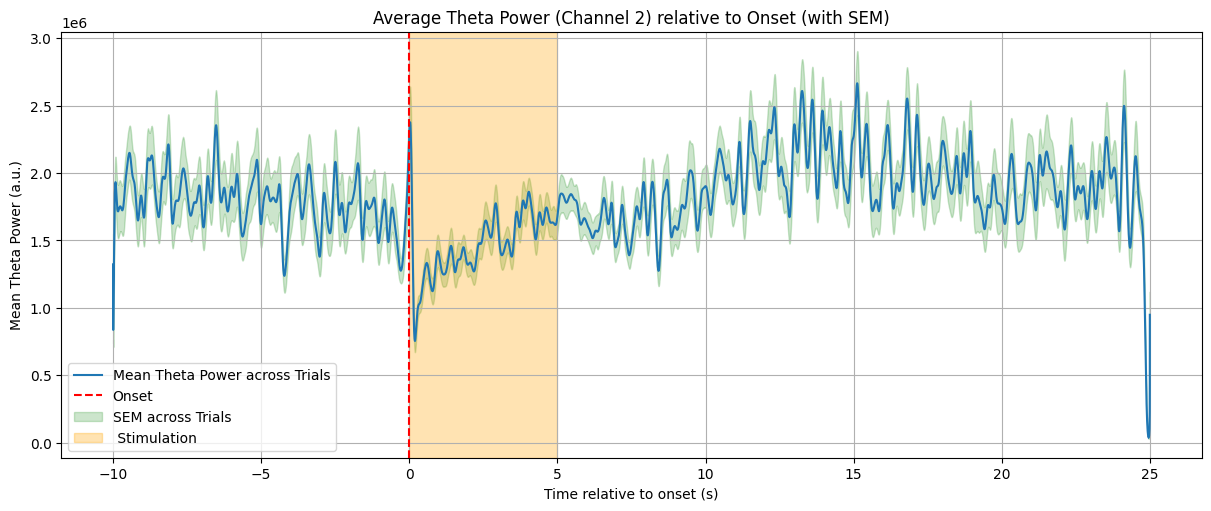

In [38]:
#Plotting the mean theta power
relative_time_axis = theta_power_by_trial[0].t - onset_times[0]

# Calculate the standard error of the mean (SEM) across trials for each time point
# First, extract the data arrays (d attribute) from each Tsd in the list
data_arrays_for_std = [tsd.d for tsd in theta_power_by_trial]

# Stack them into a 2D NumPy array (trials x time_points)
# Assuming all Tsd objects in theta_power_by_trial have the same number of data points
stacked_data = np.vstack(data_arrays_for_std)

# Calculate the standard deviation and then SEM across trials (axis=0) for each time point
std_theta_power_across_trials = np.std(stacked_data, axis=0)
num_trials_overall = stacked_data.shape[0]
sem_theta_power_across_trials = std_theta_power_across_trials / np.sqrt(num_trials_overall)

plt.figure(constrained_layout=True, figsize=(12, 5))
plt.plot(relative_time_axis, average_theta_power, label='Mean Theta Power across Trials')
plt.axvline(0, color='r', linestyle='--', label='Onset') # Mark the onset at t=0

# Add the time-varying SEM to the plot
plt.fill_between(relative_time_axis,
                 average_theta_power - sem_theta_power_across_trials,
                 average_theta_power + sem_theta_power_across_trials,
                 color='g', alpha=0.2, label='SEM across Trials')

# Add visual stimulation from 0 to 5 seconds
plt.axvspan(0, 5, color='orange', alpha=0.3, label=' Stimulation')

plt.xlabel("Time relative to onset (s)")
plt.ylabel("Mean Theta Power (a.u.)")
plt.title("Average Theta Power (Channel 2) relative to Onset (with SEM)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-790184342.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped_theta_power_data))


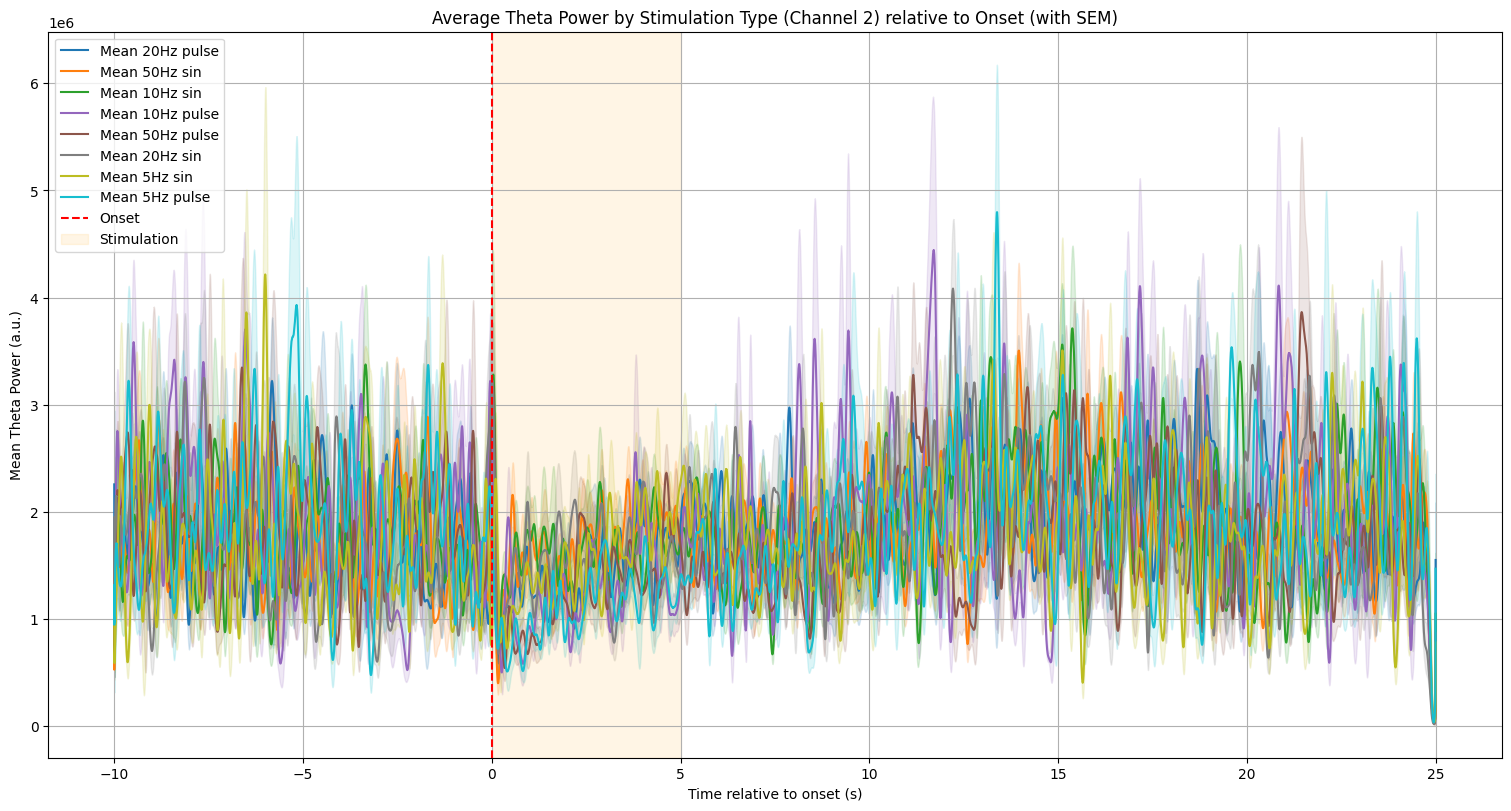

In [39]:
#Plotting by stimulation type

grouped_theta_power_data = {}

# Group theta_power_by_trial based on stimulation labels
for i, label in enumerate(trialString):
    if label not in grouped_theta_power_data:
        grouped_theta_power_data[label] = []
    grouped_theta_power_data[label].append(theta_power_by_trial[i])

# Prepare dictionaries to store mean and SEM for each stimulation type
mean_theta_power_by_stim = {}
sem_theta_power_by_stim = {}

# Reconstruct the relative time axis, which is consistent across all trials
relative_time_axis = theta_power_by_trial[0].t - onset_times[0]

# Calculate mean and SEM for each grouped stimulation type
for label, tsds in grouped_theta_power_data.items():
    # Stack the data (d attribute) from all Tsd objects for this stimulation type
    stacked_data_group = np.vstack([tsd.d for tsd in tsds])

    # Calculate standard deviation and then SEM
    std_data_group = np.std(stacked_data_group, axis=0)
    num_trials_group = stacked_data_group.shape[0]

    mean_theta_power_by_stim[label] = np.mean(stacked_data_group, axis=0)
    sem_theta_power_by_stim[label] = std_data_group / np.sqrt(num_trials_group)

# Plotting
plt.figure(constrained_layout=True, figsize=(15, 8))

# Define a color cycle for better visual distinction
colors = plt.cm.get_cmap('tab10', len(grouped_theta_power_data))

for i, label in enumerate(grouped_theta_power_data.keys()):
    plt.plot(relative_time_axis, mean_theta_power_by_stim[label], label=f'Mean {label}', color=colors(i))
    plt.fill_between(relative_time_axis,
                     mean_theta_power_by_stim[label] - sem_theta_power_by_stim[label],
                     mean_theta_power_by_stim[label] + sem_theta_power_by_stim[label],
                     color=colors(i), alpha=0.15)

plt.axvline(0, color='r', linestyle='--', label='Onset') # Mark the onset at t=0
plt.axvspan(0, 5, color='orange', alpha=0.1, label='Stimulation')

plt.xlabel("Time relative to onset (s)")
plt.ylabel("Mean Theta Power (a.u.)")
plt.title("Average Theta Power by Stimulation Type (Channel 2) relative to Onset (with SEM)")
plt.legend()
plt.grid(True)
plt.show()

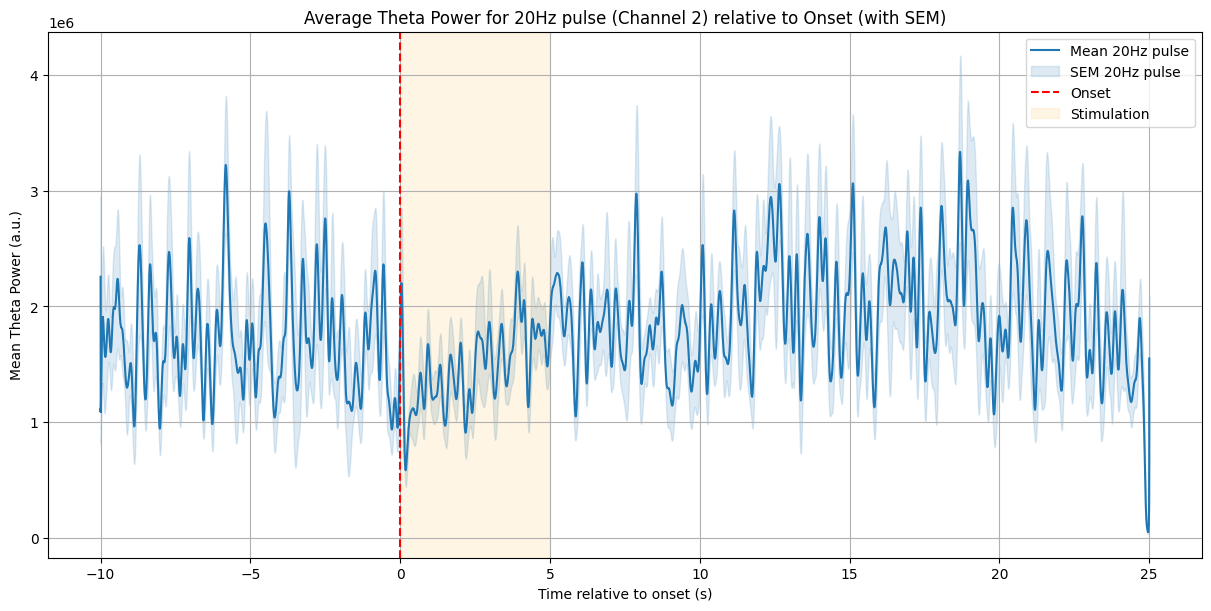

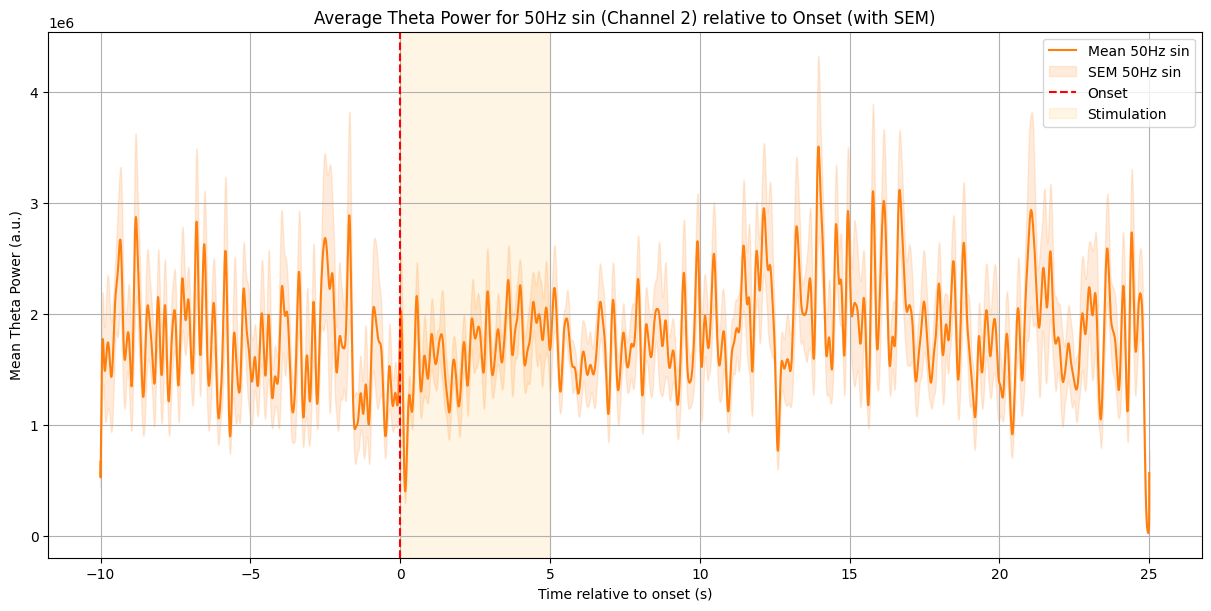

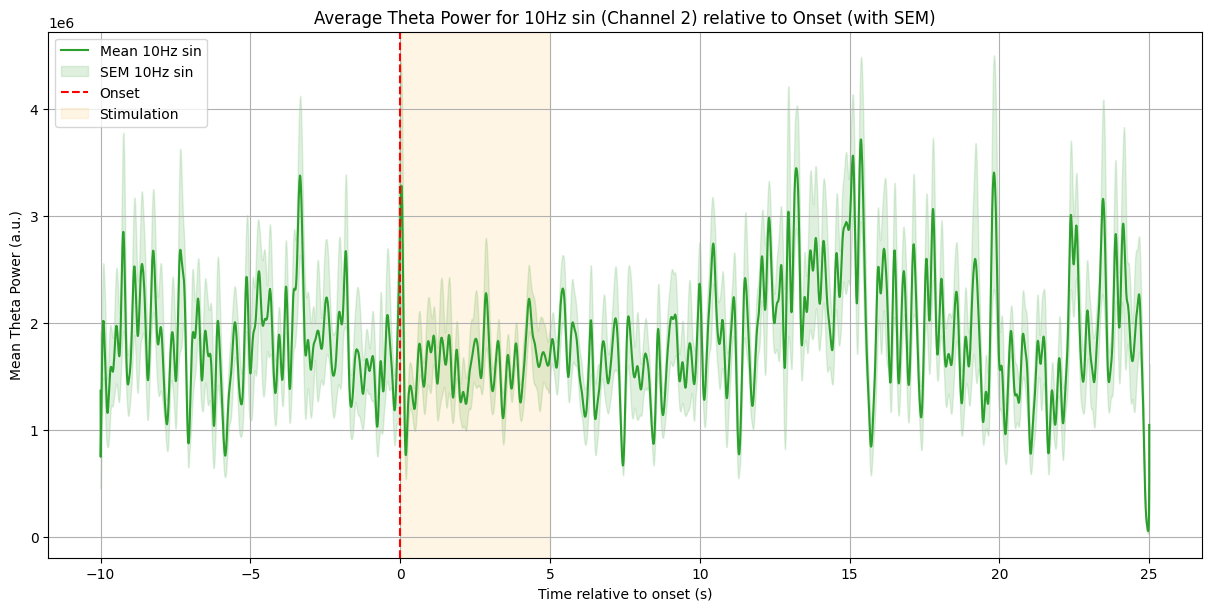

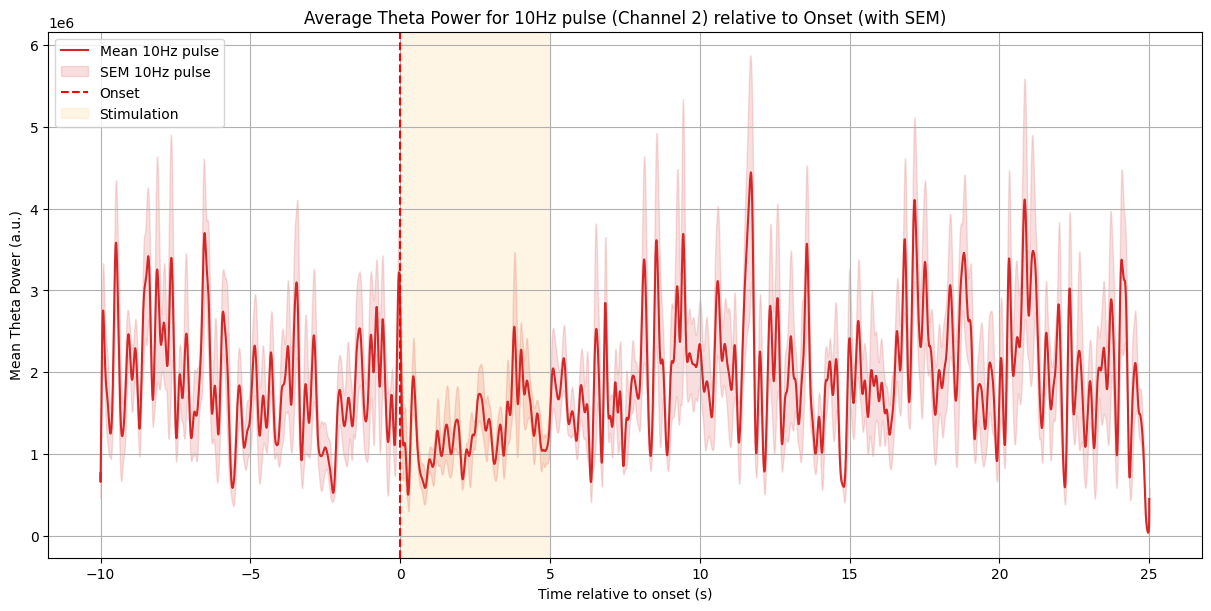

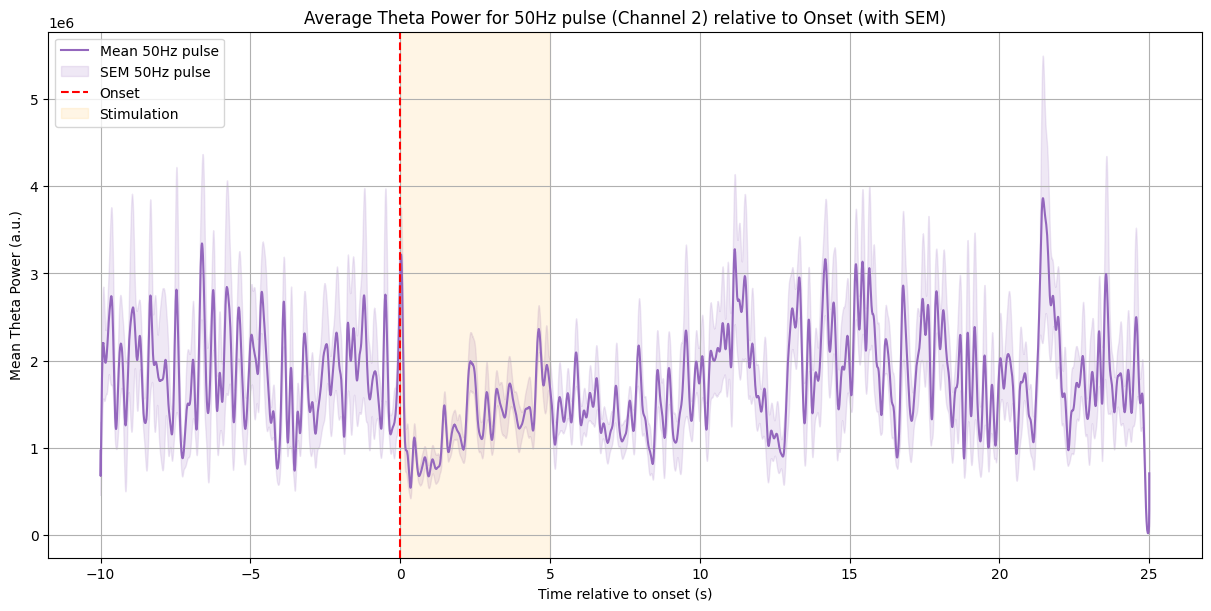

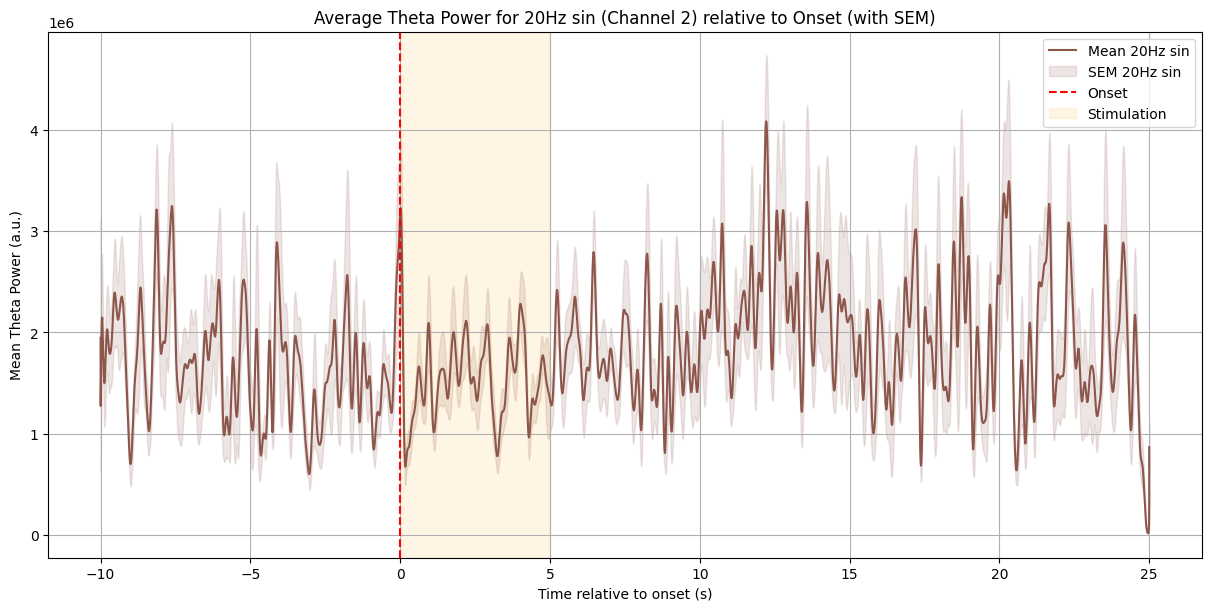

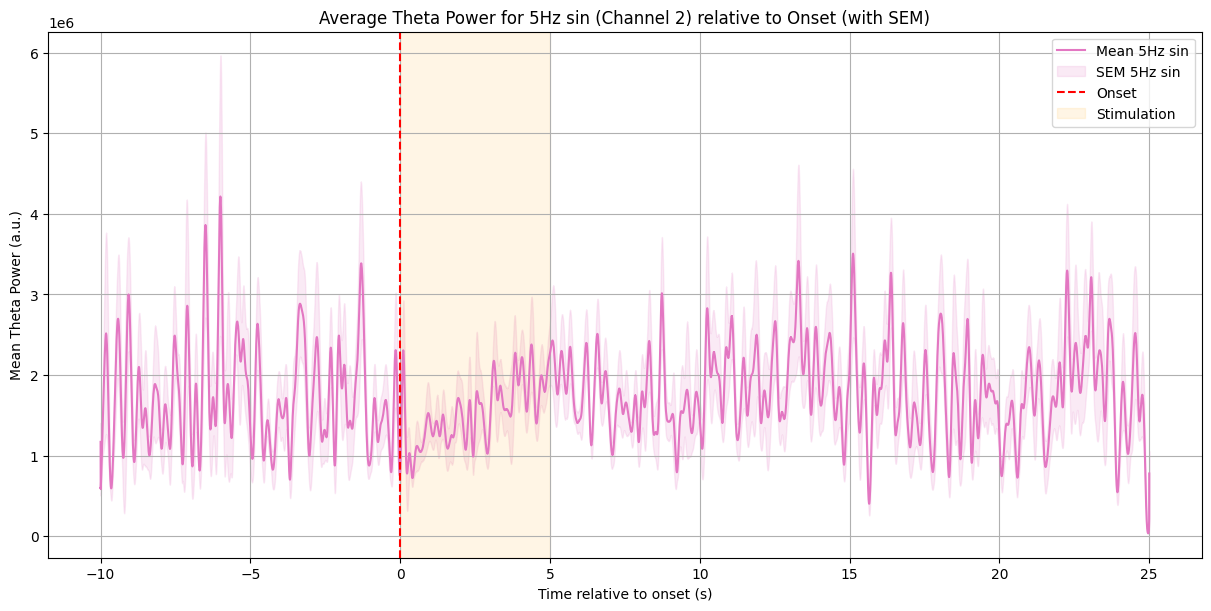

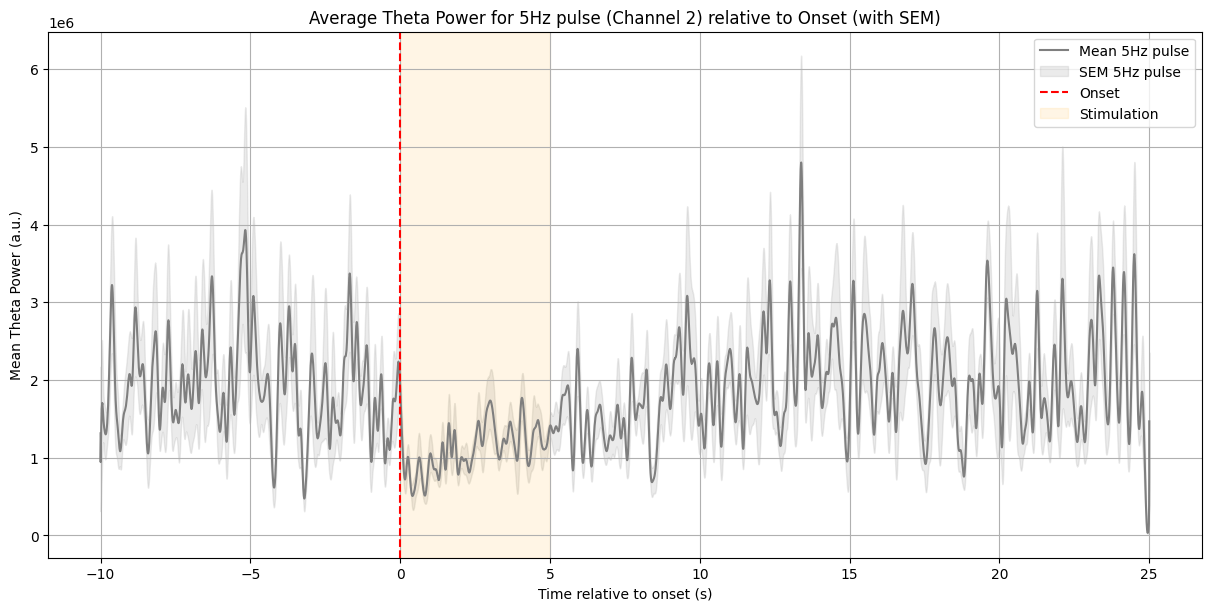

In [40]:
#Plotting stimulation type in seperate graphs

# Reconstruct the relative time axis, which is consistent across all trials
relative_time_axis = theta_power_by_trial[0].t - onset_times[0]

# Define a color cycle for better visual distinction
# Using matplotlib.colormaps.get_cmap for future compatibility
colors = plt.colormaps.get_cmap('tab10')

for i, label in enumerate(grouped_theta_power_data.keys()):
    plt.figure(constrained_layout=True, figsize=(12, 6))
    plt.plot(relative_time_axis, mean_theta_power_by_stim[label], label=f'Mean {label}', color=colors(i))
    plt.fill_between(relative_time_axis,
                     mean_theta_power_by_stim[label] - sem_theta_power_by_stim[label],
                     mean_theta_power_by_stim[label] + sem_theta_power_by_stim[label],
                     color=colors(i), alpha=0.15, label=f'SEM {label}')

    plt.axvline(0, color='r', linestyle='--', label='Onset') # Mark the onset at t=0
    plt.axvspan(0, 5, color='orange', alpha=0.1, label='Stimulation') # Add visual stimulation

    plt.xlabel("Time relative to onset (s)")
    plt.ylabel("Mean Theta Power (a.u.)")
    plt.title(f"Average Theta Power for {label} (Channel 2) relative to Onset (with SEM)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
#Identifying the stimulation with the biggest decrease in theta power

# Define baseline and stimulation time windows
baseline_start = -10.0
baseline_end = 0.0
stimulation_start = 0.0
stimulation_end = 5.0

# Find indices corresponding to these time windows in the relative_time_axis
baseline_indices = (relative_time_axis >= baseline_start) & (relative_time_axis < baseline_end)
stimulation_indices = (relative_time_axis >= stimulation_start) & (relative_time_axis <= stimulation_end)

# Dictionary to store changes in theta power
theta_power_changes = {}

for label, mean_power_data in mean_theta_power_by_stim.items():
    # Calculate average theta power during baseline
    baseline_avg_power = np.mean(mean_power_data[baseline_indices])

    # Calculate average theta power during stimulation
    stimulation_avg_power = np.mean(mean_power_data[stimulation_indices])

    # Calculate the change
    change = stimulation_avg_power - baseline_avg_power
    theta_power_changes[label] = change

# Find the stimulation type with the greatest change
greatest_change_stim = max(theta_power_changes, key=theta_power_changes.get)
greatest_change_value = theta_power_changes[greatest_change_stim]

print(f"Stimulation changes after onset (Stimulation Avg - Baseline Avg):")
for label, change_val in theta_power_changes.items():
    print(f"  {label}: {change_val:.4f}")

print(f"\nThe stimulation type with the greatest change in theta power after onset for Channel 2 is '{greatest_change_stim}' with a change of {greatest_change_value:.4f}.")

Stimulation changes after onset (Stimulation Avg - Baseline Avg):
  20Hz pulse: -255807.2403
  50Hz sin: -61749.9695
  10Hz sin: -178396.1608
  10Hz pulse: -597611.5797
  50Hz pulse: -525463.2801
  20Hz sin: -137998.2513
  5Hz sin: -200623.3182
  5Hz pulse: -825133.5713

The stimulation type with the greatest change in theta power after onset for Channel 2 is '50Hz sin' with a change of -61749.9695.
